Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [5]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [6]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [7]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [ ]:
#fuck fuck shit shit shit

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [8]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

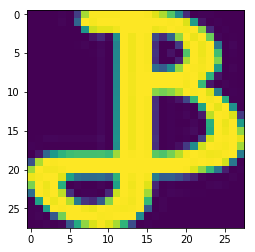

In [6]:
def sample_images(pickle_set):
    #for pickle_file in pickle_set:
        pickle_file = pickle_set[np.random.randint(len(pickle_set))]
        with open(pickle_file, 'rb') as f:
            dataset = pickle.load(f)
            size = dataset.shape[0]
            r = np.random.randint(size)
            plt.imshow(dataset[r])
        
        
#sample_images(train_datasets)
sample_images(test_datasets)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [34]:
from __future__ import division

def sample_images(pickle_set):
    sizes = []
    for pickle_file in pickle_set:
        with open(pickle_file, 'rb') as f:
            dataset = pickle.load(f)
            size = dataset.shape[0]
            sizes.append(size)
    size_total = sum(sizes)
    print('Total items:', size_total)
    print('Items in categories:', sizes)
    print('Items distribution:', [siz/size_total for siz in sizes])
        
        
sample_images(train_datasets)
sample_images(test_datasets)

Total items: 529114
Items in categories: [52909, 52911, 52912, 52911, 52912, 52912, 52912, 52912, 52912, 52911]
Items distribution: [0.09999546411548361, 0.09999924401924727, 0.1000011339711291, 0.09999924401924727, 0.1000011339711291, 0.1000011339711291, 0.1000011339711291, 0.1000011339711291, 0.1000011339711291, 0.09999924401924727]
Total items: 18724
Items in categories: [1872, 1873, 1873, 1873, 1873, 1872, 1872, 1872, 1872, 1872]
Items distribution: [0.0999786370433668, 0.1000320444349498, 0.1000320444349498, 0.1000320444349498, 0.1000320444349498, 0.0999786370433668, 0.0999786370433668, 0.0999786370433668, 0.0999786370433668, 0.0999786370433668]


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [1]:
# Sieve of Eratosthenes
# Code by David Eppstein, UC Irvine, 28 Feb 2002
# http://code.activestate.com/recipes/117119/

def gen_primes():
    """ Generate an infinite sequence of prime numbers.
    """
    # Maps composites to primes witnessing their compositeness.
    # This is memory efficient, as the sieve is not "run forward"
    # indefinitely, but only as long as required by the current
    # number being tested.
    #
    D = {}
    
    # The running integer that's checked for primeness
    q = 2
    
    while True:
        if q not in D:
            # q is a new prime.
            # Yield it and mark its first multiple that isn't
            # already marked in previous iterations
            # 
            yield q
            D[q * q] = [q]
        else:
            # q is composite. D[q] is the list of primes that
            # divide it. Since we've reached q, we no longer
            # need it in the map, but we'll mark the next 
            # multiples of its witnesses to prepare for larger
            # numbers
            # 
            for p in D[q]:
                D.setdefault(p + q, []).append(p)
            del D[q]
        
        q += 1
        
        

import itertools
primes = itertools.islice(gen_primes(), 28*28)
primes = list(primes)
primes[0] = 1

primes_matrix = np.array(primes).reshape((28,28))

In [59]:


def matrix_hash(a):
    return np.sum(a*primes_matrix)

def generate_hashes(letter_set):
    return [matrix_hash(x) for x in letter_set]

def generate_hashes_from_file(pickle_file):
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
    return (letter_set, generate_hashes(letter_set))
        
def check_duplicates_in_files(pf_train, pf_test):
    with open(pf_train, 'rb') as f:
        train_set = pickle.load(f)
    with open(pf_test, 'rb') as f:
        test_set = pickle.load(f)
    check_duplicates(train_set, test_set)
    
def check_duplicates(train_set, test_set):
    if test_set is None:
        return
    
    train_hashes = generate_hashes(train_set)
    test_hashes = generate_hashes(test_set)
    
#     for i in range(len(test_hashes)-1):
#         for j in range(i+1, len(test_hashes)):
#             if test_hashes[i] == test_hashes[j]:
#                 print(np.array_equal(test_set[i], test_set[j]))
#     print(pf_train)
    print("Test set len is", test_set.shape[0], "with", test_set.shape[0] - len(set(test_hashes)), "duplicates")    
    
#     for i in range(len(train_hashes)-1):
#         for j in range(i+1, len(train_hashes)):
#             if train_hashes[i] == train_hashes[j]:
#                 print(np.array_equal(train_set[i], train_set[j]))
                
                #plt.figure()
                #plt.imshow(test_set[i])
                #plt.figure()
                #plt.imshow(test_set[j])

    print("Train set len is", train_set.shape[0], "with", train_set.shape[0] - len(set(train_hashes)), "duplicates")    
    print("Cross set intersection:", len(set(test_hashes)&set(train_hashes)))
    
def prevent_duplicates(origin_dataset, exclude_dataset, safe_idx):
    if exclude_dataset is None:
        return origin_dataset
    
    origin_hashes = generate_hashes(origin_dataset)
    exclude_hashes = generate_hashes(exclude_dataset)
    exclude_hashes_set = set(exclude_hashes)
    
    preserving_range = safe_idx;
    for i in range(preserving_range):
        if origin_hashes[i] in exclude_hashes_set:
            while origin_hashes[safe_idx] in exclude_hashes_set:
                safe_idx+=1
            origin_dataset[[i,safe_idx]] = origin_dataset[[safe_idx, i]]
            origin_hashes[safe_idx] = origin_hashes[i]
            safe_idx+=1
#             print("safe idx", safe_idx)
    
#         for j in range(exclude_dataset.shape[0]):
#             if origin_hashes[i] == exclude_hashes[j]:
#                 while origin_hashes[safe_idx] == origin_hashes[i]:
#                     safe_idx+=1
#                 origin_hashes[[i,safe_idx]] = origin_hashes[[safe_idx, i]]
    
# for i in range(len(train_datasets)):
#     check_duplicates_in_files(train_datasets[i], test_datasets[i])
    
check_duplicates_in_files(train_datasets[8], test_datasets[8])

# a = np.arange(10).reshape((5,2))
# print (a)
# a[[1,2]] = a[[2,1]]
# print (a)

# arr, _ = generate_hashes_from_file(test_datasets[8])
# print (arr[1])
# arr[[1,2]]=arr[[2,1]]
# print (arr[1])

Test set len is 1872 with 275 duplicates
Train set len is 52912 with 11739 duplicates
Cross set intersection: 441


In [60]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0, dataset_to_exclude=None):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        check_duplicates(train_letter, dataset_to_exclude)
        print(train_letter.shape, letter_set.shape, end_l)
        
        
        prevent_duplicates(letter_set, dataset_to_exclude, end_l)
        
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        check_duplicates(train_letter, dataset_to_exclude)
        
        
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        
        check_duplicates(train_letter, dataset_to_exclude)
        
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)
valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size, test_dataset)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

(1000, 28, 28) (1872, 28, 28) 1000
(1000, 28, 28) (1873, 28, 28) 1000
(1000, 28, 28) (1873, 28, 28) 1000
(1000, 28, 28) (1873, 28, 28) 1000
(1000, 28, 28) (1873, 28, 28) 1000
(1000, 28, 28) (1872, 28, 28) 1000
(1000, 28, 28) (1872, 28, 28) 1000
(1000, 28, 28) (1872, 28, 28) 1000
(1000, 28, 28) (1872, 28, 28) 1000
(1000, 28, 28) (1872, 28, 28) 1000
Test set len is 10000 with 219 duplicates
Train set len is 20000 with 924 duplicates
Cross set intersection: 102
(20000, 28, 28) (52909, 28, 28) 21000
hit!
safe idx 21001
hit!
safe idx 21002
hit!
safe idx 21003
hit!
safe idx 21004
hit!
safe idx 21005
hit!
safe idx 21006
hit!
safe idx 21007
hit!
safe idx 21008
hit!
safe idx 21009
hit!
safe idx 21010
hit!
safe idx 21011
hit!
safe idx 21012
hit!
safe idx 21013
hit!
safe idx 21014
hit!
safe idx 21015
hit!
safe idx 21016
hit!
safe idx 21017
hit!
safe idx 21018
hit!
safe idx 21019
hit!
safe idx 21020
hit!
safe idx 21021
hit!
safe idx 21022
hit!
safe idx 21023
hit!
safe idx 21024
hit!
safe idx 21025

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [43]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Label: 1
Label: 6
Label: 4
Label: 7
Label: 3
Label: 0
Label: 2
Label: 4
Label: 3
Label: 7


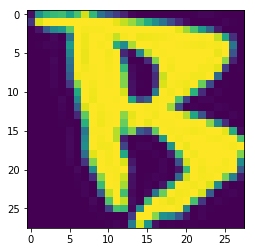

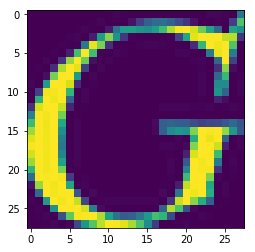

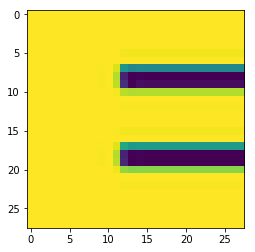

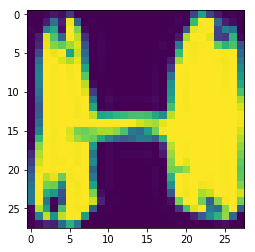

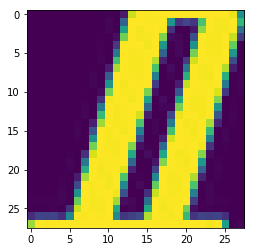

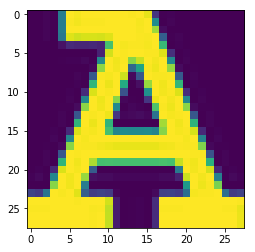

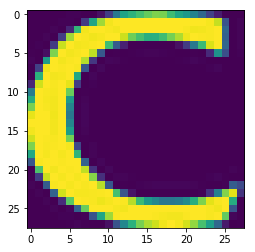

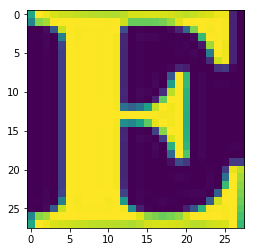

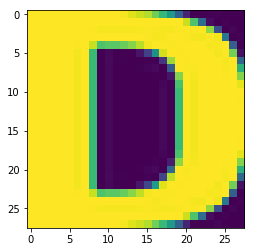

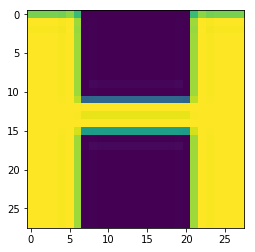

In [67]:
def check_dataset(dataset, labels, sample_size=10):
    start = np.random.randint(dataset.shape[0])
    
    for i in range(start, start + sample_size): 
        print('Label:', labels[i])
        plt.figure()
        plt.imshow(dataset[i])
    
#check_dataset(train_dataset, train_labels)
#check_dataset(test_dataset, test_labels)
check_dataset(valid_dataset, valid_labels)

Finally, let's save the data for later reuse:

In [62]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [9]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [61]:
def unique_hashes(dataset):
    #return sorted([(np.sum(tensor), tensor) for tensor in dataset], key=lambda e: e[0])
    #return len(set([np.sum(tensor) for tensor in dataset]))
    return set([tensor.tostring() for tensor in dataset])

import time
def timmilis():
    return int(round(time.time() * 1000))

print ("Duplicates inside datasets")

start = timmilis()
train_unique = unique_hashes(train_dataset)
print ("Train:", train_dataset.shape[0]-len(train_unique), '/', train_dataset.shape[0], "for", timmilis()-start, "ms")

start = timmilis()
test_unique = unique_hashes(test_dataset)
print ("Test:", test_dataset.shape[0]-len(test_unique), '/', test_dataset.shape[0], "for", timmilis()-start, "ms")

start = timmilis()
valid_unique = unique_hashes(valid_dataset)
print ("Validation:", valid_dataset.shape[0]-len(valid_unique), '/', valid_dataset.shape[0], "for", timmilis()-start, "ms")

print ("\nDuplicates cross datasets")
print ("Train-test:", len(train_unique & test_unique))
print ("Train-validation:", len(train_unique & valid_unique))
print ("Test-validation:", len(valid_unique & test_unique))

Duplicates inside datasets
Train: 10630 / 200000 for 1546 ms
Test: 219 / 10000 for 81 ms
Validation: 34 / 10000 for 75 ms

Duplicates cross datasets
Train-test: 0
Train-validation: 985
Test-validation: 0


In [1]:
print(train_dataset.shape)

print(train_labels.shape)

dataset = test_dataset;

a = sorted([(np.sum(tensor), tensor) for tensor in dataset], key=lambda e: e[0])
#a = np.random.rand(2,4,3)
#print (a)

#b = a.reshape(2,12)
#print (b)
#print (a)

NameError: name 'train_dataset' is not defined

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [191]:
lc = LogisticRegression(verbose=1, n_jobs=-1)

train_set_size = 10000 #5000 #1000 #50
tds = train_dataset[0:train_set_size,:,:]
tl = np.ndarray((train_set_size, 10))
tl[...] = [[(1 if lbl==i else 0) for i in range(10)] for lbl in train_labels[0:train_set_size]]

x = tds.reshape(tds.shape[0], 28*28)
# y = tl
y = train_labels[:train_set_size]
# print(y.shape)
lc.fit(x, y)
#print(x, y)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)

In [192]:
np.set_printoptions(precision=5, suppress=True)

def check_accuracy(dataset, labels):

    correct = 0
    
    for sample_idx in range(len(labels)):
#     sample_idx = np.random.randint(train_set_size)

        test_input = dataset.reshape(dataset.shape[0], 28*28)[sample_idx]
        test_label = labels[sample_idx]

        prediction = lc.predict_proba(test_input.reshape(1, -1))
        max_index, max_value = max(enumerate(prediction[0]), key=lambda el: el[1])

        if test_label == max_index:
            correct += 1
#         print (test_label == max_index, max_value);

#         plt.figure()
#         plt.imshow(tds[sample_idx])
    return float(correct) / len(labels)

# acc = check_accuracy(tds, tl)
# print ("Accuracy on train dataset:", acc)

acc = check_accuracy(test_dataset, test_labels)
print ("Accuracy on test dataset:", acc)

acc = check_accuracy(valid_dataset, valid_labels)
print ("Accuracy on validation dataset:", acc)

# a = np.ndarray((3))
# a[...] = [1,2,3]
# print (a)
# a.reshape(1,-1)
# print (a)

Accuracy on test dataset: 0.864
Accuracy on validation dataset: 0.7793
